FF++ provided mask videos for the dataset.

First, utilize provided masks to reduce the overall dataset image size.

Since the sizes of masks are not consistent in different manipulation types, the first mask based crop must be further processed to eliminate the distribution difference.

So we will run cropped dataset on neural network based detector to make it consistent in face/background ratio and get rid of frames without face to increase dataset quality.

In [3]:
import sys
if '../../' not in sys.path:
    sys.path.append('../../')
from Utils.FileOperation import *
from Config import rootDir

import numpy as np
from PIL import Image
import time
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import math

In [4]:
def calculate_mean_frame_count(video_paths):
    frame_counts = []

    for path in video_paths:
        cap = cv2.VideoCapture(path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_counts.append(frame_count)
        cap.release()

    mean_frame_count = statistics.mean(frame_counts)
    median_frame_count = statistics.median(frame_counts)
    max_frame_count = max(frame_counts)
    min_frame_count = min(frame_counts)

    return mean_frame_count, median_frame_count, max_frame_count, min_frame_count, frame_counts

def get_frame_ranges(frame_counts, bar_width):
    frame_ranges = []
    for frame_count in frame_counts:
        frame_range = (frame_count // bar_width) * bar_width
        frame_ranges.append(frame_range)
    return frame_ranges

In [7]:
def extract(
        mask_path,
        data_path,
        output_path,
        padding=0,
        center_tweaks=(0,0),
        smooth_level=0
    ):
    '''
    Parameters:
        mask_path: Path to the mask video
        data_path: Path to the original video
        output_path: Path to the output video
        padding: Number of pixels to add as margin to the original bounding box
        center_tweaks: Tweaks to the center of the bounding box
        smooth_level: Number of frames to smooth the bounding box
    '''
    # Task 1: Load mask video
    mask_video = cv2.VideoCapture(mask_path)

    # Task 2: Find bounding box for each frame in the mask video
    bounding_boxes = []
    max_w, max_h = 0, 0
    while mask_video.isOpened():
        success, frame = mask_video.read()
        if not success:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            # Find the largest contour (assumed to be the face shape)
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            center = (x + w // 2, y + h // 2)
            center = (int(center[0] * (1 + center_tweaks[0])), int(center[1] * (1 + center_tweaks[1])))

            # Adjust bounding box aspect ratio
            aspect_ratio = 1.0
            h = int(max((w * (2 * padding + 1) * aspect_ratio), h * (2 * padding + 1)))
            w = int(h // aspect_ratio)
            x, y = int(center[0] - w // 2), int(center[1] - h // 2)

            max_w, max_h = max(max_w, w), max(max_h, h)

            bounding_boxes.append((x, y, x+w, y+h))
        else:
            # Set bounding box to (0, 0, 0, 0) when no contour is detected (pure black frame)
            print('\nNo bounding box found at frame', len(bounding_boxes))
            bounding_boxes.append((0, 0, 0, 0))

    mask_video.release()
    max_h = max(max_h, int(max_w * aspect_ratio))
    max_w = max(max_w, int(max_h // aspect_ratio))

    # Task 3: Load original video
    original_video = cv2.VideoCapture(data_path)

    # Task 4: Crop original video frames using the mask's bounding boxes with PIL.Image
    cropped_frames = []

    for idx in range(len(bounding_boxes)):
        success, frame = original_video.read()
        if not success:
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if bounding_boxes[idx] != (0, 0, 0, 0):
            # Smooth bounding boxes
            id_0 = max(0, idx - smooth_level // 2)
            id_1 = min(len(bounding_boxes), idx + 1 + math.ceil(smooth_level / 2))
            curr_bounding_box = smooth_frames(bounding_boxes[id_0:id_1])
            
            cropped_frame = Image.fromarray(frame).crop(curr_bounding_box)
            cropped_frames.append(cropped_frame)

    # Task 5: Resize cropped frames and save as a video
    # Assume the face will be 0.3 times of width and height after padding,
    # since we will use 224*224 resized image in training, larger sizes will be a waste of computation in the latter NN based detection phase
    max_w = min(max_w, 224 * 3)
    max_h = min(max_h, 224 * 3)
    output_size = (max_w, max_h)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30.0, output_size)

    for frame in cropped_frames:
        resized_frame = frame.resize(output_size)
        out.write(cv2.cvtColor(np.array(resized_frame), cv2.COLOR_RGB2BGR))

    out.release()


def smooth_frames(bounding_boxes):
    '''
    Smooth bounding boxes using linear interpolation
    Parameters:
        bounding_boxes: List of bounding boxes, length of list means smooth level
    Return:
        One smoothed bounding box
    '''

    # Filter out (0, 0, 0, 0) bounding boxes
    filtered_boxes = [box for box in bounding_boxes if box != (0, 0, 0, 0)]
    
    if len(filtered_boxes) == 0:
        return (0, 0, 0, 0)

    # Linear interpolation of bounding boxes
    x0, y0, x1, y1 = 0, 0, 0, 0
    for bounding_box in filtered_boxes:
        x0 += bounding_box[0]
        y0 += bounding_box[1]
        x1 += bounding_box[2]
        y1 += bounding_box[3]

    x0, y0, x1, y1 = int(x0 / len(filtered_boxes)), int(y0 / len(filtered_boxes)), int(x1 / len(filtered_boxes)), int(y1 / len(filtered_boxes))
    return (x0, y0, x1, y1)

Mean frame count: 509.128
Median frame count: 457.5
Maximum frame count: 1814
Minimum frame count: 287


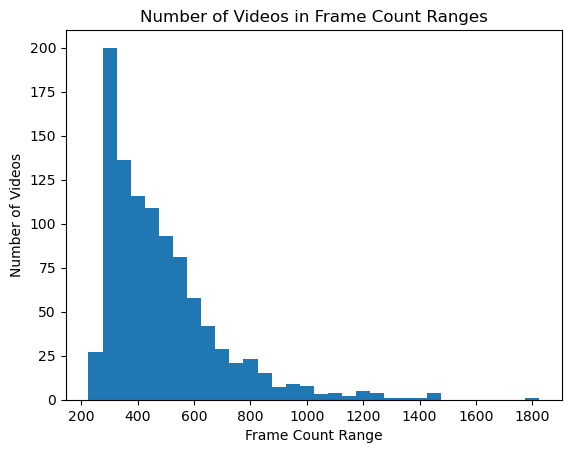

In [3]:
realDir = rootDir + 'FF++/c23/real/'
# Find length distribution of data
video_paths = [realDir + i for i in ls(realDir)]
mean_frames, median_frames, max_frames, min_frames, frame_counts = calculate_mean_frame_count(video_paths)
print(f"Mean frame count: {mean_frames}")
print(f"Median frame count: {median_frames}")
print(f"Maximum frame count: {max_frames}")
print(f"Minimum frame count: {min_frames}")

# Define the bar width for frame ranges
bar_width = 50

# Get the frame ranges for each video
frame_ranges = get_frame_ranges(frame_counts, bar_width)

# Count the number of videos in each frame range
frame_ranges_counter = Counter(frame_ranges)

# Prepare the data for plotting
x_values = list(frame_ranges_counter.keys())
y_values = list(frame_ranges_counter.values())

# Plotting the bar chart
plt.bar(x_values, y_values, width=bar_width)
plt.xlabel('Frame Count Range')
plt.ylabel('Number of Videos')
plt.title('Number of Videos in Frame Count Ranges')
plt.show()

In [4]:
dataDirs = [
    rootDir + 'FF++/c23/fake/Deepfakes/',
    rootDir + 'FF++/c23/fake/Face2Face/',
    rootDir + 'FF++/c23/fake/FaceSwap/',
    rootDir + 'FF++/c23/fake/NeuralTextures/',
]
# Number of pixels to pad on each manipulating method, it's manully set to a large number so we can have pixels to crop in the latter NN based detection phase
paddings = [1.0, 0.6, 0.5, 0.5]
center_tweaks = [(0,0),(0,0),(0,0),(0,-0.05)] # (x,y) tweaks to the center of the face corresponding to the methods
smooth_levels = [5, 3, 3, 3] # Level of smoothing to apply to the mask corresponding to the methods
for dataDir, padding, center_tweak, smooth_level in zip(dataDirs, paddings, center_tweaks, smooth_levels):
    maskDir = dataDir.replace('c23/fake', 'masks')
    saveDir = dataDir.replace('FF++', 'cropped_videos/FF++_crop_basic')
    vidDirs = ls(dataDir)
    savedList = ls(saveDir)
    for vidDir in vidDirs:
        if vidDir in savedList:
            saved = cv2.VideoCapture(saveDir + vidDir)
            saved_frame_count = int(saved.get(cv2.CAP_PROP_FRAME_COUNT))
            saved.release()
            original = cv2.VideoCapture(dataDir + vidDir)
            original_frame_count = int(original.get(cv2.CAP_PROP_FRAME_COUNT))
            original.release()
            if saved_frame_count == original_frame_count:
                continue
        print(time.ctime(time.time()), ':', dataDir + vidDir)
        try:
            extract(
                maskDir + vidDir,
                dataDir + vidDir,
                saveDir + vidDir,
                padding,
                center_tweak,
                smooth_level
            )
        except:
            print("\n>>>>>>>>>> ERROR OCCURED <<<<<<<<<<")
realDir = rootDir + 'FF++/c23/real/'
dataDir = realDir
maskDir = dataDirs[0].replace('c23/fake', 'masks') # Real videos can share the same masks with Deepfakes
saveDir = realDir.replace('FF++', 'cropped_videos/FF++_crop_basic')
vidDirs = ls(dataDir)
savedList = ls(saveDir)
maskVidDirs = ls(maskDir)
for vidDir, maskVidDir in zip(vidDirs, maskVidDirs):
    if vidDir in savedList:
        saved = cv2.VideoCapture(saveDir + vidDir)
        saved_frame_count = int(saved.get(cv2.CAP_PROP_FRAME_COUNT))
        saved.release()
        original = cv2.VideoCapture(dataDir + vidDir)
        original_frame_count = int(original.get(cv2.CAP_PROP_FRAME_COUNT))
        original.release()
        if saved_frame_count == original_frame_count:
            continue
    print(time.ctime(time.time()), ':', dataDir + vidDir)
    try:
        extract(
            maskDir + maskVidDir,
            dataDir + vidDir,
            saveDir + vidDir,
            paddings[0],
            center_tweaks[0],
            smooth_levels[0]
        )
    except:
        print("\n>>>>>>>>>> ERROR OCCURED <<<<<<<<<<")

Wed Mar 13 18:35:47 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/000_003.mp4
Wed Mar 13 18:35:48 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/001_870.mp4
Wed Mar 13 18:35:51 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/002_006.mp4
Wed Mar 13 18:35:57 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/003_000.mp4
Wed Mar 13 18:35:58 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/004_982.mp4
Wed Mar 13 18:35:59 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/005_010.mp4
Wed Mar 13 18:36:00 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/006_002.mp4
Wed Mar 13 18:36:03 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/007_132.mp4
Wed Mar 13 18:36:04 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/008_990.mp4
Wed Mar 13 18:36:05 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/009_027.mp4
Wed Mar 13 18:36:08 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Deepfakes/010_005.mp4

In [5]:
dataDirs = [
    rootDir + 'FF++/c40/fake/Deepfakes/',
    rootDir + 'FF++/c40/fake/Face2Face/',
    rootDir + 'FF++/c40/fake/FaceSwap/',
    rootDir + 'FF++/c40/fake/NeuralTextures/',
]
# Number of pixels to pad on each manipulating method, it's manully set to a large number so we can have pixels to crop in the latter NN based detection phase
paddings = [1.0, 0.6, 0.5, 0.5]
center_tweaks = [(0,0),(0,0),(0,0),(0,-0.05)] # (x,y) tweaks to the center of the face corresponding to the methods
smooth_levels = [5, 3, 3, 3] # Level of smoothing to apply to the mask corresponding to the methods
for dataDir, padding, center_tweak, smooth_level in zip(dataDirs, paddings, center_tweaks, smooth_levels):
    maskDir = dataDir.replace('c40/fake', 'masks')
    saveDir = dataDir.replace('FF++', 'cropped_videos/FF++_crop_basic')
    vidDirs = ls(dataDir)
    savedList = ls(saveDir)
    for vidDir in vidDirs:
        if vidDir in savedList:
            saved = cv2.VideoCapture(saveDir + vidDir)
            saved_frame_count = int(saved.get(cv2.CAP_PROP_FRAME_COUNT))
            saved.release()
            original = cv2.VideoCapture(dataDir + vidDir)
            original_frame_count = int(original.get(cv2.CAP_PROP_FRAME_COUNT))
            original.release()
            if saved_frame_count == original_frame_count:
                continue
        print(time.ctime(time.time()), ':', dataDir + vidDir)
        try:
            extract(
                maskDir + vidDir,
                dataDir + vidDir,
                saveDir + vidDir,
                padding,
                center_tweak,
                smooth_level
            )
        except:
            print("\n>>>>>>>>>> ERROR OCCURED <<<<<<<<<<")
realDir = rootDir + 'FF++/c40/real/'
dataDir = realDir
maskDir = dataDirs[0].replace('c40/fake', 'masks') # Real videos can share the same masks with Deepfakes
saveDir = realDir.replace('FF++', 'cropped_videos/FF++_crop_basic')
vidDirs = ls(dataDir)
savedList = ls(saveDir)
maskVidDirs = ls(maskDir)
for vidDir, maskVidDir in zip(vidDirs, maskVidDirs):
    if vidDir in savedList:
        saved = cv2.VideoCapture(saveDir + vidDir)
        saved_frame_count = int(saved.get(cv2.CAP_PROP_FRAME_COUNT))
        saved.release()
        original = cv2.VideoCapture(dataDir + vidDir)
        original_frame_count = int(original.get(cv2.CAP_PROP_FRAME_COUNT))
        original.release()
        if saved_frame_count == original_frame_count:
            continue
    print(time.ctime(time.time()), ':', dataDir + vidDir)
    try:
        extract(
            maskDir + maskVidDir,
            dataDir + vidDir,
            saveDir + vidDir,
            paddings[0],
            center_tweaks[0],
            smooth_levels[0]
        )
    except:
        print("\n>>>>>>>>>> ERROR OCCURED <<<<<<<<<<")

Wed Mar 13 22:56:45 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/000_003.mp4
Wed Mar 13 22:56:46 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/001_870.mp4
Wed Mar 13 22:56:49 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/002_006.mp4
Wed Mar 13 22:56:55 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/003_000.mp4
Wed Mar 13 22:56:56 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/004_982.mp4
Wed Mar 13 22:56:57 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/005_010.mp4
Wed Mar 13 22:56:58 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/006_002.mp4
Wed Mar 13 22:57:01 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/007_132.mp4
Wed Mar 13 22:57:02 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/008_990.mp4
Wed Mar 13 22:57:03 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/009_027.mp4
Wed Mar 13 22:57:05 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/010_005.mp4

**NOTICE**

227 is in test set, but it will be abandoned in the next process due to its broken manipulation

So we will crop it to a proper size here, and move it into the dataset folder manully

In [9]:
saveDir + vidDir

'/home/kyr/GazeForensicsData/cropped_videos/FF++_crops_basic/special/c40_NeuralTextures_227_169.mp4'

In [11]:
dataDirs = [
    rootDir + 'FF++/c40/fake/Face2Face/',
    rootDir + 'FF++/c40/fake/NeuralTextures/',
]
# Number of pixels to pad on each manipulating method, it's manully set to a large number so we can have pixels to crop in the latter NN based detection phase
paddings = [0.1, 0.085]
center_tweaks = [(0,0),(0,-0.05)] # (x,y) tweaks to the center of the face corresponding to the methods
smooth_levels = [3, 3] # Level of smoothing to apply to the mask corresponding to the methods
for dataDir, padding, center_tweak, smooth_level in zip(dataDirs, paddings, center_tweaks, smooth_levels):
    maskDir = dataDir.replace('c40/fake', 'masks')
    saveDir = rootDir + 'cropped_videos/FF++_crop_basic/special/' + dataDir.split('/')[-4] + '_' + dataDir.split('/')[-2] + '_'
    vidDirs = ls(dataDir)
    for vidDir in vidDirs:
        if '227_' in vidDir:
            break
    print(time.ctime(time.time()), ':', dataDir + vidDir)
    extract(
        maskDir + vidDir,
        dataDir + vidDir,
        saveDir + vidDir,
        padding,
        center_tweak,
        smooth_level
    )

dataDirs = [
    rootDir + 'FF++/c23/fake/Face2Face/',
    rootDir + 'FF++/c23/fake/NeuralTextures/',
]
# Number of pixels to pad on each manipulating method, it's manully set to a large number so we can have pixels to crop in the latter NN based detection phase
paddings = [0.1, 0.085]
center_tweaks = [(0,0),(0,-0.05)] # (x,y) tweaks to the center of the face corresponding to the methods
smooth_levels = [3, 3] # Level of smoothing to apply to the mask corresponding to the methods
for dataDir, padding, center_tweak, smooth_level in zip(dataDirs, paddings, center_tweaks, smooth_levels):
    maskDir = dataDir.replace('c23/fake', 'masks')
    saveDir = rootDir + 'cropped_videos/FF++_crop_basic/special/' + dataDir.split('/')[-4] + '_' + dataDir.split('/')[-2] + '_'
    vidDirs = ls(dataDir)
    for vidDir in vidDirs:
        if '227_' in vidDir:
            break
    print(time.ctime(time.time()), ':', dataDir + vidDir)
    extract(
        maskDir + vidDir,
        dataDir + vidDir,
        saveDir + vidDir,
        padding,
        center_tweak,
        smooth_level
    )

Thu Mar 14 21:56:19 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/Face2Face/227_169.mp4
Thu Mar 14 21:56:24 2024 : /home/kyr/GazeForensicsData/FF++/c40/fake/NeuralTextures/227_169.mp4
Thu Mar 14 21:56:27 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/Face2Face/227_169.mp4
Thu Mar 14 21:56:32 2024 : /home/kyr/GazeForensicsData/FF++/c23/fake/NeuralTextures/227_169.mp4
